# Preamble

In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir('..')
os.path.realpath(os.path.curdir)

'/Users/byronsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time

In [ ]:
import sfacts as sf

In [4]:
all_species_gtpro_depth = pd.read_table(f'data/hmp2.a.r.proc.gtpro.species_depth.tsv', dtype=dict(sample=str, species_id=str, depth=float), index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0)
all_species_gtpro_depth

species_id,100003,100013,100014,100016,100017,100018,100022,100027,100028,100029,...,104498,104526,104533,104557,104593,104600,104637,104639,104643,104644
sample,,,,,,,,,,,,,,,,,,,,,
CSM5FZ4M_G110153,0.000000,0.0,0.0,0.000000,0.0,0.0,8.894045,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CSM5MCUO_G110157,0.407445,0.0,0.0,0.000000,0.0,0.0,3.172363,0.0,4.133927,0.000000,...,0.0,0.040332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CSM5MCVL_G110038,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CSM5MCVN_G110144,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CSM5MCW6_G110147,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMB4MBS_G110702,0.968813,0.0,0.0,1.751582,0.0,0.0,2.523603,0.0,0.370429,0.000000,...,0.0,1.578346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
PSMB4MC1_G111932,0.000000,0.0,0.0,1.426045,0.0,0.0,18.887759,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
PSMB4MC3_G111934,0.000000,0.0,0.0,0.000000,0.0,0.0,3.818494,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [5]:
species_taxonomy = pd.read_table('ref/gtpro/species_taxonomy_ext.tsv', names=['genome_id', 'species_id', 'taxonomy_string']).assign(species_id=lambda x: x.species_id.astype(str)).set_index('species_id')[['taxonomy_string']].assign(taxonomy_split=lambda x: x.taxonomy_string.str.split(';'))

for level_name, level_number in [('p__', 1), ('c__', 2), ('o__', 3), ('f__', 4), ('g__', 5), ('s__', 6)]:
    species_taxonomy = species_taxonomy.assign(**{level_name: species_taxonomy.taxonomy_split.apply(lambda x: x[level_number])}) 
species_taxonomy = species_taxonomy.drop(columns=['taxonomy_split']).loc[all_species_gtpro_depth.columns]

In [6]:
(all_species_gtpro_depth > 0.5).sum().sort_values(ascending=False)

species_id
102478    1118
101346     992
102492     879
102438     857
101378     842
          ... 
100268       0
100111       0
101521       0
103335       0
104138       0
Length: 545, dtype: int64

In [7]:
species_id = '102506'

In [8]:
species_taxonomy.loc[species_id]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

In [9]:
fit = sf.World.load(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.world.nc').drop_low_abundance_strains(0.05)
fit.sizes

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Frozen({'strain': 110, 'position': 10000, 'sample': 624, 'allele': 2})

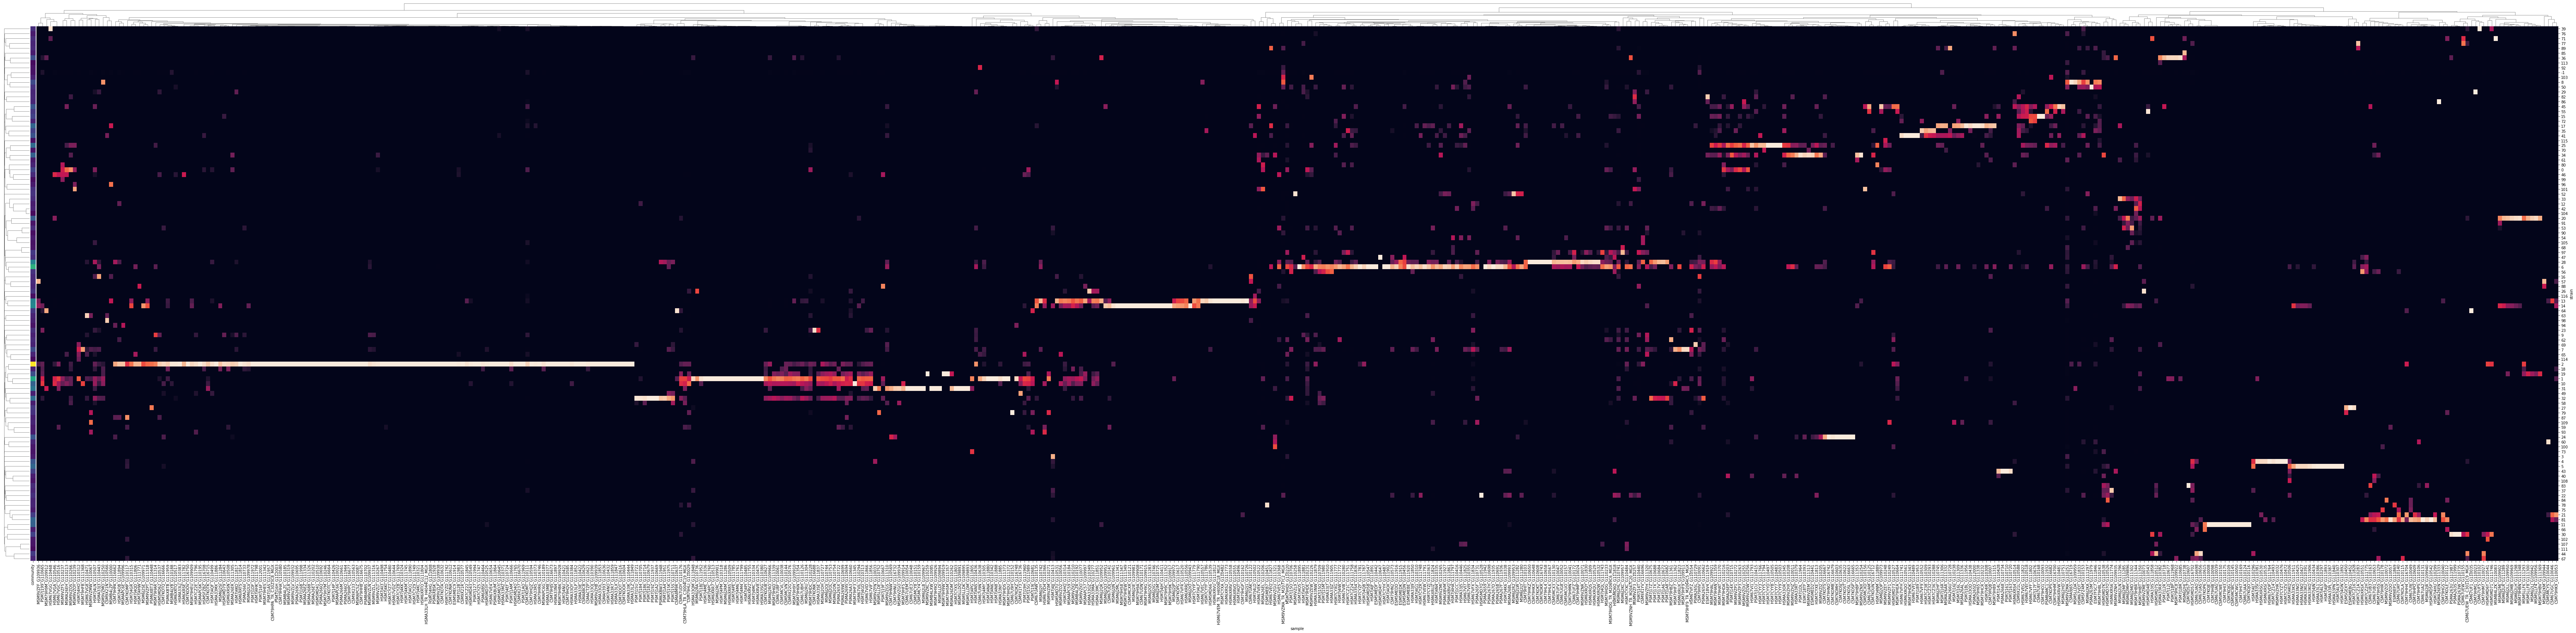

In [10]:
# sf.plot.plot_community(w25, col_linkage_func=lambda w: w.metagenotype.linkage())
sf.plot.plot_community(fit, col_linkage_func=lambda w: w.metagenotype.linkage())

In [15]:
strain_frac = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.comm.tsv', index_col=['sample', 'strain']).squeeze().unstack(fill_value=0)
strain_frac.shape

(624, 125)

In [16]:
species_gene_depth = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.species_depth.tsv', names=['sample', 'depth'], index_col='sample').squeeze()
gtpro_depth = pd.read_table(f'data/hmp2.a.r.proc.gtpro.species_depth.tsv', dtype=dict(sample=str, species_id=str, depth=float), index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0)[species_id]

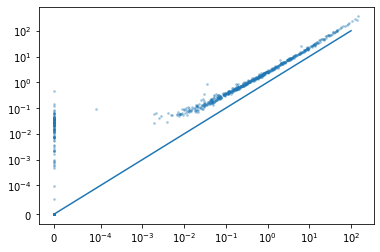

In [17]:
d = pd.DataFrame(dict(gene=species_gene_depth, gtpro=gtpro_depth))

plt.scatter('gtpro', 'gene', data=d, s=3, alpha=0.3)
plt.plot([0, 1e2], [0, 1e2])
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)

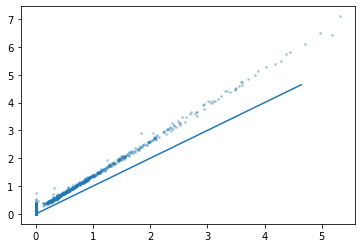

In [18]:
d = pd.DataFrame(dict(gene=species_gene_depth, gtpro=gtpro_depth))

_trnsf = np.cbrt

plt.scatter('gtpro', 'gene', data=_trnsf(d), s=3, alpha=0.3)
plt.plot([_trnsf(0), _trnsf(1e2)], [_trnsf(0), _trnsf(1e2)])
# plt.yscale('symlog', linthresh=1e-4)
# plt.xscale('symlog', linthresh=1e-4)

In [19]:
species_corr = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.species_correlation.tsv', names=['sample', 'correlation'], index_col='sample').squeeze()
species_depth_ratio = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.species_depth_ratio.tsv', names=['sample', 'depth_ratio'], index_col='sample').squeeze()

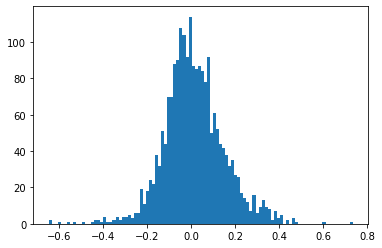

In [20]:
plt.hist(np.log10(species_depth_ratio[species_corr > 0.95]), bins=100)
None

In [21]:
np.log10(species_depth_ratio[species_corr > 0.95]).std()

0.13801693073685276

In [22]:
strain_corr_75 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene75.strain_correlation.tsv', index_col=['gene_id', 'strain']).squeeze().unstack(fill_value=0)
strain_depth_75 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene75.strain_depth_ratio.tsv', index_col=['gene_id', 'strain']).squeeze().unstack()
strain_corr_75, strain_depth_75 = align_indexes(*align_indexes(strain_corr_75, strain_depth_75), axis="columns")

In [67]:
gene_meta = pd.read_table(f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt').set_index('centroid_99', drop=False).rename_axis(index='gene_id')

In [174]:
gene_annotations = pd.read_table('ref_temp/midasdb_uhgg.102506.centroid_75.tsv', index_col='locus_tag')
cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta

,categories,description,gene,pathway,_1,_2
cog,,,,,,
COG0001,H,Glutamate-1-semialdehyde aminotransferase,HemL,Heme biosynthesis,NaN,2CFB
COG0002,E,N-acetyl-gamma-glutamylphosphate reductase,ArgC,Arginine biosynthesis,NaN,3DR3
COG0003,P,"Anion-transporting ATPase, ArsA/GET3 family",ArsA,NaN,NaN,1F48
COG0004,P,Ammonia channel protein AmtB,AmtB,NaN,NaN,1U77
COG0005,F,Purine nucleoside phosphorylase,XapA,Purine salvage,NaN,1YQQ
...,...,...,...,...,...,...
COG5946,V,CRISPR-Cas system type I-G effector complex su...,Csb5gr5,CRISPR-Cas system,NaN,NaN
COG5947,V,CRISPR-Cas system type I-D effector complex su...,Csc1gr5,CRISPR-Cas system,NaN,NaN
COG5948,V,CRISPR-Cas system type I-D effector complex su...,Csc2gr7,CRISPR-Cas system,NaN,NaN


In [215]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

In [23]:
gene_depth_75 = xr.load_dataarray(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.depth.nc')

In [24]:
species_genes = idxwhere(species_corr > 0.95)

In [26]:
strain_threshold = pd.read_table(
    f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene75.strain_correlation_threshold.tsv',
    names=['strain', 'threshold'], index_col='strain',
).squeeze()
# strain_threshold.to_frame().assign(ratio_log_depth_std=ratio_log_depth_std).sort_values('ratio_log_depth_std').head(20)
strain_threshold.sort_values(ascending=False)

strain
43    0.999178
28    0.997407
15    0.996912
25    0.995420
11    0.993650
30    0.992922
4     0.990253
24    0.989767
17    0.965109
6     0.963396
14    0.960818
5     0.957061
2     0.937979
13    0.927565
32    0.924262
31    0.905097
1     0.892892
Name: threshold, dtype: float64

In [94]:
strain = 15

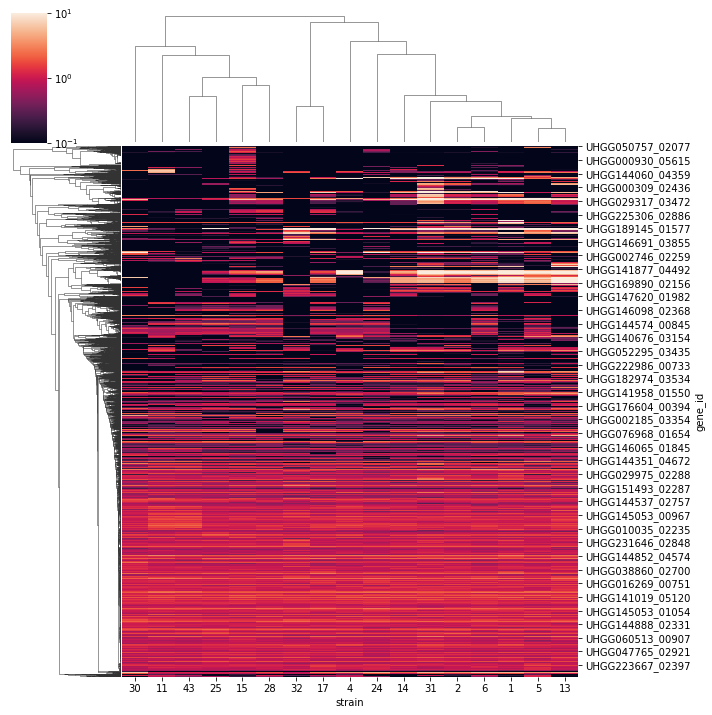

In [96]:
d = strain_depth_75[
    strain_corr_75[strain]
    # > 0.8
    > strain_threshold[strain]
]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10)
)

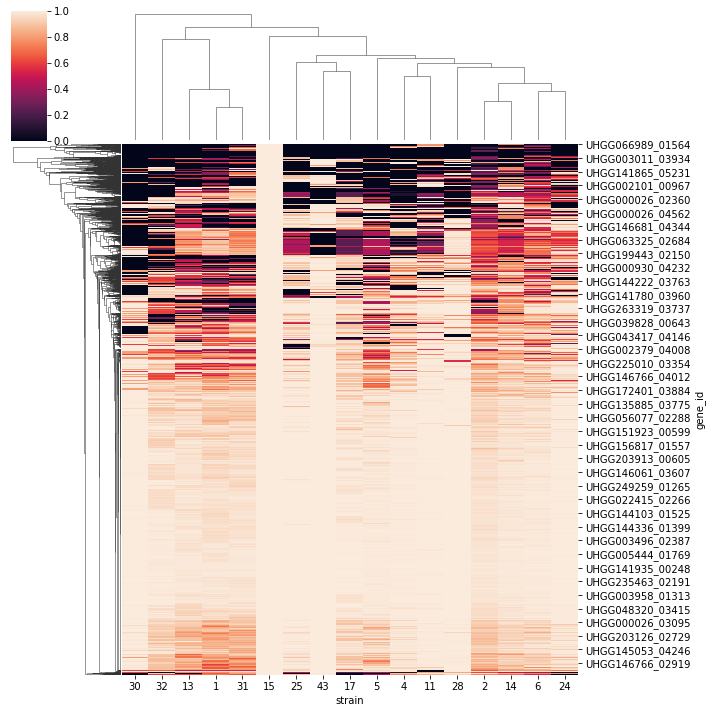

In [97]:
d = strain_corr_75[
    strain_corr_75[strain]
    # > 0.8
    > strain_threshold[strain]
]

sns.clustermap(
    d,
    metric='cosine',
)

(7033, 2)


/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


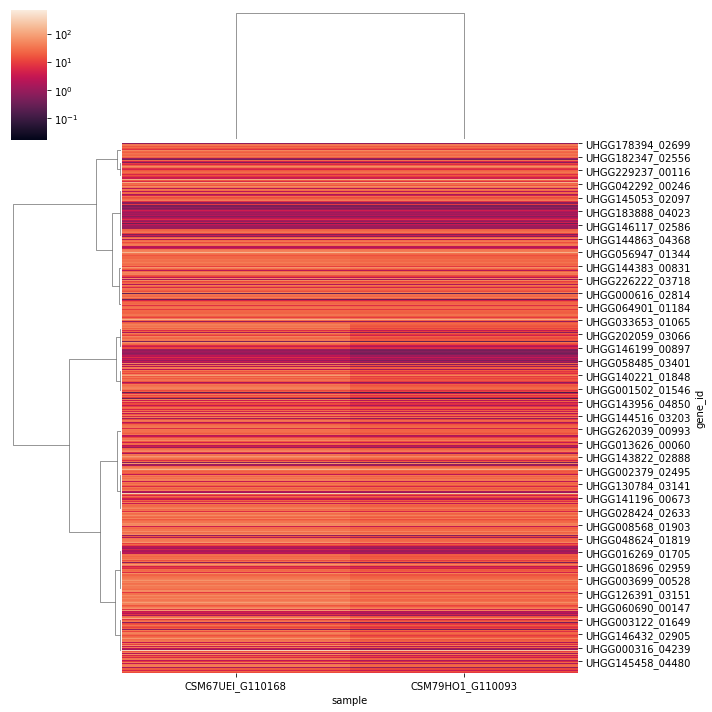

In [98]:
d = gene_depth_75.sel(
    gene_id=idxwhere(
        strain_corr_75[strain]
        > strain_threshold[strain]
        # > 0.8
    ),
    sample=idxwhere(strain_frac[strain] > 0.95),
).to_series().unstack()
print(d.shape)

sns.clustermap(d, metric='cosine', norm=mpl.colors.SymLogNorm(linthresh=0.1))

/Users/byronsmith/Projects/strain-corr/include/StrainFacts/sfacts/plot.py:150: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


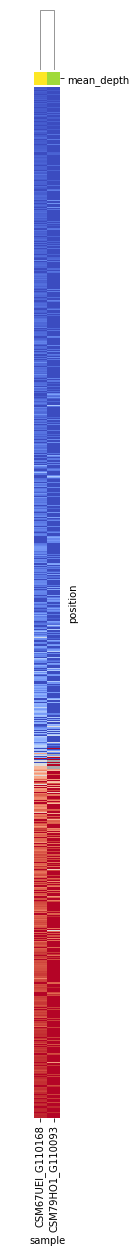

In [99]:
sample_list = idxwhere(strain_frac[strain] > 0.95)
mgen_allele_totals = fit.metagenotype.sel(sample=sample_list).sum("sample")
position_order = (
    (
        mgen_allele_totals.sel(allele="alt")
        / mgen_allele_totals.sum("allele")
    )
    .to_series()
    .dropna()
    [lambda x: (0 < x) & (1 > x)]
    .sort_values()
    .index
)

sf.plot.plot_metagenotype(
    fit.sel(
        sample=sample_list,
        position=position_order,
    ),
    # row_cluster=False,
)

0.996912025521914 7033 5660.629907259328 5660.629907259327


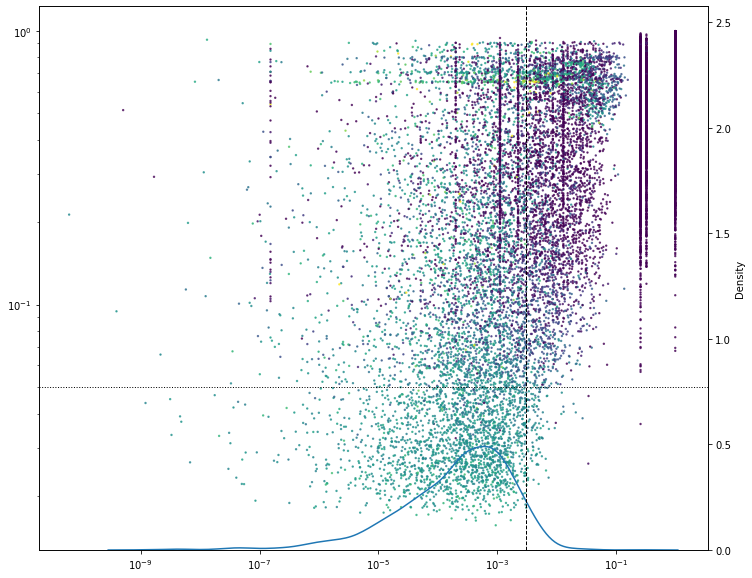

In [100]:
species_corr_thresh = 0.95
strain_corr_quantile = 0.95


d0 = pd.DataFrame(dict(
    strain_max_diss=1 - strain_corr_75[strain].groupby(gene_meta.centroid_75).max(),
    species_diss=1 - species_corr,
    depth_ratio=strain_depth_75[strain].groupby(gene_meta.centroid_75).sum(),
))

fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(
    'strain_max_diss', 'species_diss', c='depth_ratio', data=d0,
    s=2, alpha=0.7, norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=1e-1, vmax=10),
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(1 - species_corr_thresh, lw=1, linestyle=':', c='k')

ax1 = ax.twinx()
d1 = d0[d0['species_diss'] < (1 - species_corr_thresh)]
sns.kdeplot(d1.strain_max_diss, ax=ax1)
ax1.set_ylim(ymax=ax1.get_ylim()[1] * 5)
q = 1 - d1.strain_max_diss.quantile(strain_corr_quantile)
ax1.axvline(1 - q, lw=1, linestyle='--', c='k')

print(
    q,
    (d0.strain_max_diss < 1 - q).sum(),
    d0[d0.strain_max_diss < 1 - q].depth_ratio.sum(),
    (strain_depth_75[strain] * (strain_corr_75[strain] > q)).sum()
)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_36367/3728258344.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  gene_list = idxwhere((strain_corr_75 > strain_threshold).any(1))
/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


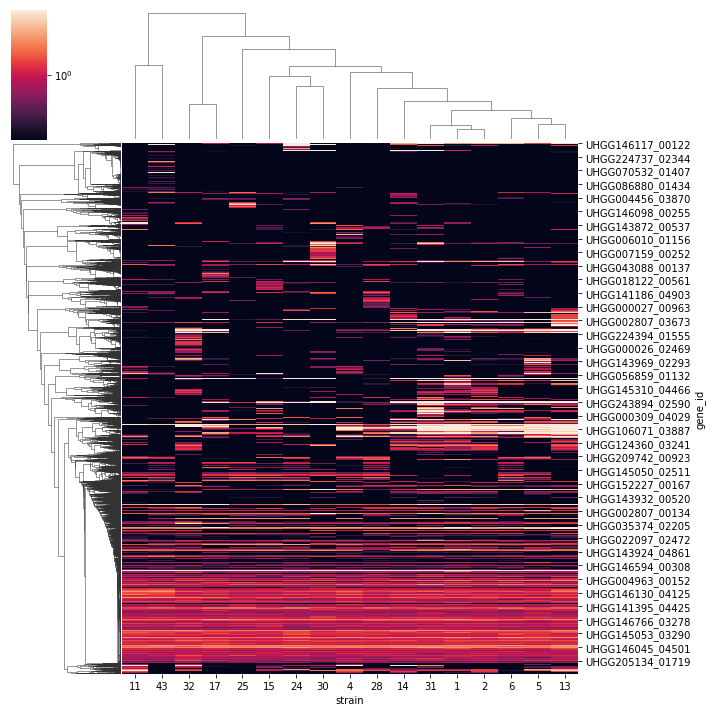

In [102]:
gene_list = idxwhere((strain_corr_75 > strain_threshold).any(1))
d = strain_depth_75.loc[gene_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_36367/833899314.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  gene_list = idxwhere((strain_corr_75 > strain_threshold).any(1))
/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


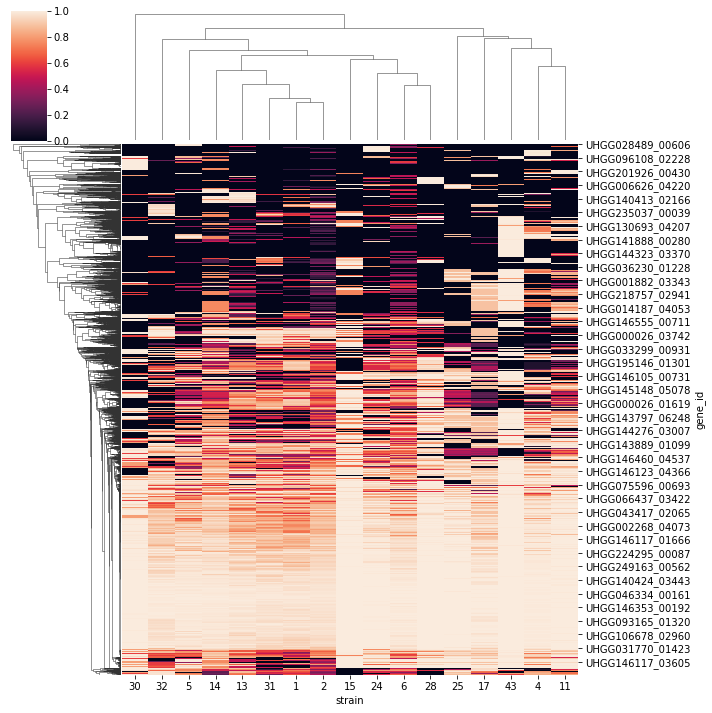

In [103]:
gene_list = idxwhere((strain_corr_75 > strain_threshold).any(1))
d = strain_corr_75.loc[gene_list]

sns.clustermap(
    d,
    metric='cosine',
)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_36367/2180746288.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  gene_list = idxwhere((strain_corr_75 > strain_threshold).any(1))
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_36367/2180746288.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  corr_hit = strain_corr_75.loc[gene_list] > strain_threshold


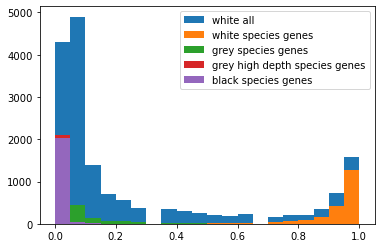

In [199]:
depth_ratio_bound = 5

gene_list = idxwhere((strain_corr_75 > strain_threshold).any(1))
depth_hit = (strain_depth_75.loc[gene_list] < depth_ratio_bound) & (strain_depth_75.loc[gene_list] > 1 / depth_ratio_bound)
high_depth = strain_depth_75 > depth_ratio_bound
corr_hit = strain_corr_75.loc[gene_list] > strain_threshold
white = depth_hit & corr_hit
grey = depth_hit ^ corr_hit
black = ~depth_hit & ~corr_hit
grey_high_depth = corr_hit & high_depth

bins = np.linspace(0, 1, num=21)

plt.hist(white.mean(1), bins=bins, label='white all')
plt.hist(white.mean(1)[species_corr > 0.95], bins=bins, label='white species genes')
plt.hist(grey.mean(1)[species_corr > 0.95], bins=bins, label='grey species genes')
plt.hist(grey_high_depth.mean(1)[species_corr > 0.95], bins=bins, label='grey high depth species genes')
plt.hist(black.mean(1)[species_corr > 0.95], bins=bins, label='black species genes')

plt.legend()
None

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


tRNA modification                           29
Aminoacyl-tRNA synthetases                  12
TCA cycle                                   12
Aromatic amino acid biosynthesis            12
Fatty acid biosynthesis                     11
Menaquinone biosynthesis                    11
Heme biosynthesis                           11
Isoleucine, leucine, valine biosynthesis    11
16S rRNA modification                       10
Mureine biosynthesis                        10
Name: pathway, dtype: int64
   categories                                      description
E         136              Amino acid transport and metabolism
M         108           Cell wall/membrane/envelope biogenesis
G         107            Carbohydrate transport and metabolism
C         103                 Energy production and conversion
J         102  Translation, ribosomal structure and biogenesis
P          71           Inorganic ion transport and metabolism
H          66                Coenzyme transport and metabolis

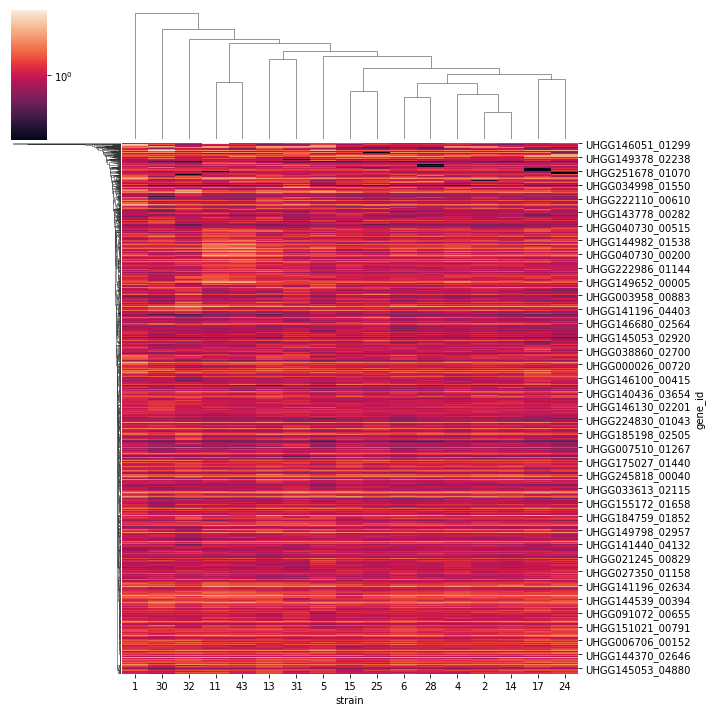

In [217]:
genes_list = idxwhere(white.mean(1) > 0.9)
d = strain_depth_75.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(
    gene_annotations
    .loc[genes_list]
    .COG.to_frame()
    .join(cog_meta, on='COG')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)

print(
    gene_annotations
    .loc[genes_list]
    .COG.to_frame()
    .join(cog_meta, on='COG')
    .categories
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
    .join(cog_category)
)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Non-phosphorylated Entner-Doudoroff pathway    9
Cobalamine/B12 biosynthesis                    7
Glycolysis                                     6
Pyrimidine salvage                             5
23S rRNA modification                          5
Aromatic amino acid biosynthesis               5
tRNA modification                              4
Ubiquinone biosynthesis                        4
Fatty acid biosynthesis                        4
Arginine biosynthesis                          4
Name: pathway, dtype: int64
    categories                             description
G           96   Carbohydrate transport and metabolism
M           67  Cell wall/membrane/envelope biogenesis
E           61     Amino acid transport and metabolism
K           36                           Transcription
LX          35                                     NaN
L           34   Replication, recombination and repair
V           24                      Defense mechanisms
C           23        Energy production an

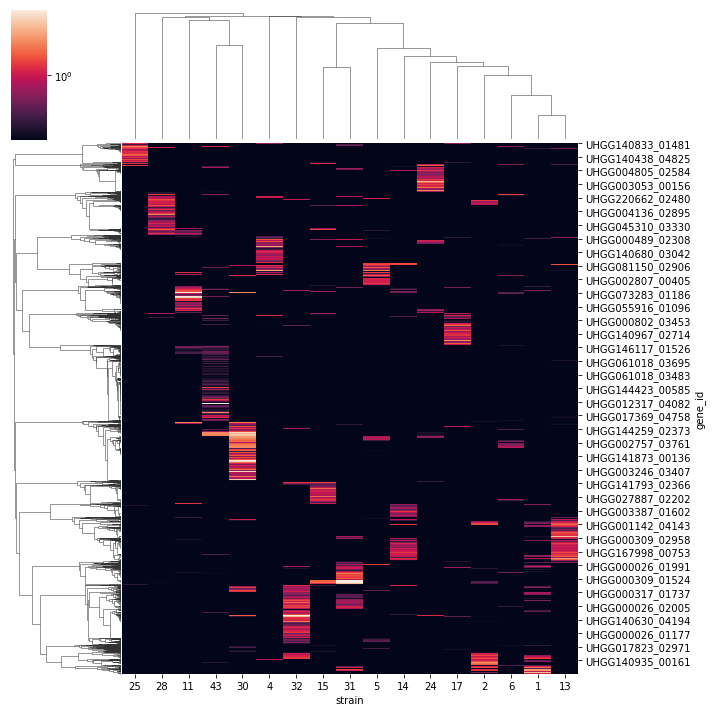

In [218]:
genes_list = idxwhere((white.mean(1) > 0.05) & (black.mean(1) > 0.8))
d = strain_depth_75.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(
    gene_annotations
    .loc[genes_list]
    .COG.to_frame()
    .join(cog_meta, on='COG')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)

print(
    gene_annotations
    .loc[genes_list]
    .COG.to_frame()
    .join(cog_meta, on='COG')
    .categories
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
    .join(cog_category)
)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Glycolysis                                     9
Fatty acid biosynthesis                        8
TCA cycle                                      7
Non-phosphorylated Entner-Doudoroff pathway    6
Lysine biosynthesis                            4
Glutamine biosynthesis                         3
Pentose phosphate pathway                      3
Serine biosynthesis                            2
Isoleucine, leucine, valine biosynthesis       2
NAD biosynthesis                               2
Name: pathway, dtype: int64
   categories                             description
G          70   Carbohydrate transport and metabolism
K          25                           Transcription
M          24  Cell wall/membrane/envelope biogenesis
E          18     Amino acid transport and metabolism
C          18        Energy production and conversion
P          17  Inorganic ion transport and metabolism
N          16                           Cell motility
V          13                      Defense mechani

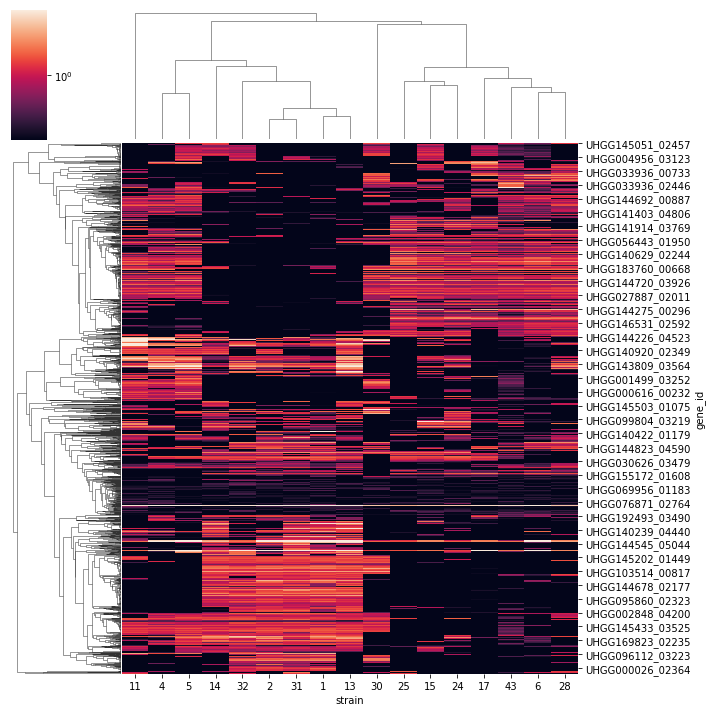

In [219]:
genes_list = idxwhere((white.mean(1) > 0.2) & (black.mean(1) > 0.2))
d = strain_depth_75.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(
    gene_annotations
    .loc[genes_list]
    .COG.to_frame()
    .join(cog_meta, on='COG')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)

print(
    gene_annotations
    .loc[genes_list]
    .COG.to_frame()
    .join(cog_meta, on='COG')
    .categories
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
    .join(cog_category)
)

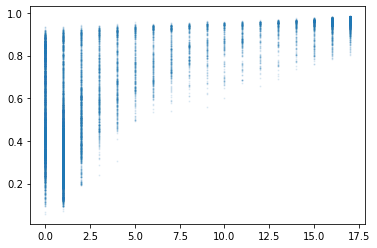

In [144]:
y = species_corr
x = white.sum(1)
x, y = align_indexes(x, y)

plt.scatter(x, y, alpha=0.1, s=1)

In [171]:
d0 = gene_depth_75.sel(
    gene_id=idxwhere(species_corr > 0.95),
).to_series().unstack()

x = gtpro_depth
y = (d0.std() / d0.mean()).sort_values(ascending=False)

d1 = pd.DataFrame(dict(x=x, y=y))

plt.scatter('x', 'y', data=d1, s=1)
plt.yscale('log')
plt.xscale('log')

# sns.clustermap(
#     d,
#     metric='cosine',
#     norm=mpl.colors.SymLogNorm(linthresh=0.1),
# )

number_genes_in_depth_range = ((strain_depth_75 > 0.2) & (strain_depth_75 < 5)).sum()
number_genes_in_depth_range

In [25]:
gene_meta = pd.read_table(f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt').set_index('centroid_99', drop=False).rename_axis(index='gene_id')

In [90]:
thresh = 5

genes_in_depth_range = (strain_depth_75 < thresh) & (strain_depth_75 > 1 / thresh)
ratio_genes_in_depth_range = (
    (genes_in_depth_range & (strain_corr_75 > strain_meta.strain_selection_threshold)).sum()
    / genes_in_depth_range.sum()
)

ratio_genes_in_depth_range

strain
32    0.712975
1     0.409949
2     0.403949
4     0.659997
5     0.536424
6     0.408284
11    0.559518
43    0.624404
13    0.488241
14    0.465399
15    0.763216
17    0.595793
24    0.712512
25    0.692636
28    0.642778
30    0.836946
31    0.453257
dtype: float64

In [93]:
strain_meta.number_strain_agg_hit

strain
32    1999
1     1999
2     1999
4     1999
5     1999
6     1999
11    1999
43    1999
13    1999
14    1999
15    1999
17    1999
24    1999
25    1999
28    1999
30    1999
31    1999
Name: number_strain_species_agg_hit, dtype: int64

In [95]:
thresh = 5

genes_in_depth_range = (strain_depth_75 < thresh) & (strain_depth_75 > 1 / thresh)
genes_in_depth_range_and_hit = (genes_in_depth_range & (strain_corr_75 > strain_meta.strain_selection_threshold))

ratio_genes_in_depth_range = genes_in_depth_range_and_hit.sum() / genes_in_depth_range.sum()
frac_genes_in_depth_range = genes_in_depth_range_and_hit.sum() / strain_meta.number_strain_agg_hit

frac_genes_in_depth_range

strain
32    0.954610
1     0.900941
2     0.997891
4     0.923046
5     0.963420
6     0.973609
11    0.859221
43    0.639581
13    0.981481
14    0.990007
15    0.741078
17    0.907340
24    0.953761
25    0.931889
28    0.947778
30    0.827059
31    0.967363
dtype: float64

In [29]:
gene_depth_99 = xr.load_dataarray(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene99.depth.nc')
gene_depth_95 = xr.load_dataarray(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene95.depth.nc')
gene_depth_75 = xr.load_dataarray(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.depth.nc')

In [30]:
strain_corr_99 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene99.strain_correlation.tsv', index_col=['gene_id', 'strain']).squeeze().unstack(fill_value=0)
strain_depth_99 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene99.strain_depth_ratio.tsv', index_col=['gene_id', 'strain']).squeeze().unstack()
strain_corr_99, strain_depth_99 = align_indexes(*align_indexes(strain_corr_99, strain_depth_99), axis="columns")

In [31]:
strain_corr_95 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene95.strain_correlation.tsv', index_col=['gene_id', 'strain']).squeeze().unstack(fill_value=0)
strain_depth_95 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene95.strain_depth_ratio.tsv', index_col=['gene_id', 'strain']).squeeze().unstack()
strain_corr_95, strain_depth_95 = align_indexes(*align_indexes(strain_corr_95, strain_depth_95), axis="columns")

In [32]:
strain_corr_90 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene90.strain_correlation.tsv', index_col=['gene_id', 'strain']).squeeze().unstack(fill_value=0)
strain_depth_90 = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene90.strain_depth_ratio.tsv', index_col=['gene_id', 'strain']).squeeze().unstack()
strain_corr_90, strain_depth_90 = align_indexes(*align_indexes(strain_corr_90, strain_depth_90), axis="columns")

In [129]:
(strain_frac > 0.95).sum().sort_values(ascending=False).head(20)

strain
5      30
30     22
17     21
76     20
38     17
0      16
110    15
67     14
73     13
57     13
47     13
39     13
96     12
42     12
19     12
59     12
15     12
6      11
53     11
63     11
dtype: int64

,gene_id,strain,depth_ratio
0,UHGG000026_00004,2,0.564849
1,UHGG000026_00004,1,0.365141
2,UHGG000026_00004,14,0.000000
3,UHGG000026_00004,31,0.626736
4,UHGG000026_00004,11,0.000000
...,...,...,...
3386875,UHGG286636_03336,17,0.009126
3386876,UHGG286636_03336,30,0.000000
3386877,UHGG286636_03336,15,0.012140
3386878,UHGG286636_03336,43,0.009433


In [111]:
# Snakefile
species='102506'
stemA='hmp2.a.r.proc'
stemB='filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0'
centroid='90'

import pandas as pd
from scipy.stats import trim_mean
from lib.pandas_util import align_indexes, idxwhere

# Script Args
outpath = f"data_temp/sp-{species}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation_threshold.tsv"
species_corr_path=f"data_temp/sp-{species}.{stemA}.midas_gene75.species_correlation.tsv"
strain_corr_path=f"data_temp/sp-{species}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation.tsv"
gene_meta_path=f"ref_temp/midasdb_uhgg/pangenomes/{species}/cluster_info.txt"  # TODO: Add to recipe
strain_depth_path=f"data_temp/sp-{species}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_depth_ratio.tsv"  # Only used for depth profiling
aggregate_genes_by="centroid_75"
species_corr_threshold=float(0.95)
strain_corr_quantile=float(0.95)
trim_frac=float(0.2)  # Only used for calculating mean species-gene depth




species_corr_agg = pd.read_table(species_corr_path, names=['gene_id', 'correlation'], index_col='gene_id').squeeze()
strain_corr = pd.read_table(strain_corr_path, index_col=['gene_id', 'strain']).squeeze().unstack(fill_value=0)
gene_meta = pd.read_table(gene_meta_path).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
strain_depth = pd.read_table(strain_depth_path, index_col=['gene_id', 'strain']).squeeze().unstack()

# Align Data
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis='columns')

strain_corr_agg = strain_corr.groupby(gene_meta[aggregate_genes_by]).max()
strain_depth_agg = strain_depth.groupby(gene_meta[aggregate_genes_by]).sum()
species_corr_agg, strain_corr_agg, strain_depth_agg = align_indexes(species_corr_agg, strain_corr_agg, strain_depth_agg)


# Calculate the strain correlation threshold for each strain at which strain_corr_quantile
# of the species genes (defined as those passing the species_corr_threshold)
# are also assigned to the strain.
species_agg_hit = species_corr_agg > species_corr_threshold
number_species_agg_hit = species_agg_hit.sum()
strain_selection_threshold = strain_corr_agg.reindex(idxwhere(species_agg_hit)).quantile(1 - strain_corr_quantile)

# Stats on aggregated gene hits (aggs where best hit is over threshold)
strain_agg_hit = strain_corr_agg.gt(strain_selection_threshold)
number_strain_agg_hit = strain_agg_hit.sum()
total_depth_ratio_strain_agg_hit = (strain_depth_agg * strain_agg_hit).sum()

# Stats on aggregated gene hits (aggs where best hit is over threshold) that were also species hits
strain_species_agg_hit = (agg_hit.T & species_agg_hit).T
number_strain_species_agg_hit = strain_species_agg_hit.sum()
total_depth_ratio_species_agg_hit = (strain_depth_agg.T * species_agg_hit).T.sum()
total_depth_ratio_strain_species_agg_hit = (strain_depth_agg * strain_species_agg_hit).sum()
mean_depth_ratio_strain_species_agg_hit = (strain_depth_agg[strain_species_agg_hit]).apply(lambda x: trim_mean(x.dropna(), proportiontocut=trim_frac))
mean_depth_ratio_species_agg_hit = (strain_depth_agg[species_agg_hit]).apply(lambda x: trim_mean(x.dropna(), proportiontocut=trim_frac))
# TODO: Calculate ratio of total depth ratios between "known" species aggs and the strain-specific aggs.
# frac_total_depth_ratio_species_agg_hit = total_depth_ratio_strain_species_agg_hit / total_depth_ratio_species_agg_hit

# Stats on gene hits (not aggregated)
strain_gene_hit = strain_corr.gt(strain_selection_threshold)

agg_depth_ratio_strain_gene_hit = strain_depth[strain_gene_hit].groupby(gene_meta[aggregate_genes_by]).sum().reindex(species_corr_agg.index).fillna(0)
agg_tally_strain_gene_hit = strain_depth[strain_gene_hit].notna().groupby(gene_meta[aggregate_genes_by]).sum().reindex(species_corr_agg.index).fillna(0).sum()
number_strain_gene_hit = agg_tally_strain_gene_hit.sum()
total_depth_ratio_strain_gene_hit = agg_depth_ratio_strain_gene_hit.sum()


# Stats on gene hits aggregated after selection
number_strain_species_gene_hit = agg_tally_strain_gene_hit[species_agg_hit].sum()
total_depth_ratio_strain_species_gene_hit = agg_depth_ratio_strain_gene_hit[species_agg_hit].sum()



mean_depth_ratio_strain_species_gene_hit = agg_depth_ratio_strain_gene_hit[species_agg_hit].apply(trim_mean, proportiontocut=trim_frac)
# TODO: Calculate ratio of depth ratios between "known" species genes and the newly identified genes.
# frac_total_depth_ratio_species_gene_hit = total_depth_ratio_strain_species_gene_hit / total_depth_ratio_species_agg_hit

out = pd.DataFrame(dict(
    strain_selection_threshold=strain_selection_threshold,
    number_species_agg=number_species_agg_hit,
    number_strain_agg_hit=number_strain_agg_hit,
    total_depth_ratio_strain_agg_hit=total_depth_ratio_strain_agg_hit,
    number_strain_species_agg_hit=number_strain_species_agg_hit,
    total_depth_ratio_species_agg_hit=total_depth_ratio_species_agg_hit,
    total_depth_ratio_strain_species_agg_hit=total_depth_ratio_strain_species_agg_hit,
    # frac_total_depth_ratio_species_agg_hit=frac_total_depth_ratio_species_agg_hit,
    mean_depth_ratio_strain_species_agg_hit=mean_depth_ratio_strain_species_agg_hit,
    mean_depth_ratio_species_agg_hit=mean_depth_ratio_species_agg_hit,
    number_strain_gene_hit=number_strain_gene_hit,
    total_depth_ratio_strain_gene_hit=total_depth_ratio_strain_gene_hit,
    number_strain_species_gene_hit=number_strain_species_gene_hit,
    total_depth_ratio_strain_species_gene_hit=total_depth_ratio_strain_species_gene_hit,
    mean_depth_ratio_strain_species_gene_hit=mean_depth_ratio_strain_species_gene_hit,
))

# out.to_csv(...

In [124]:
strain_depth[strain_gene_hit].notna().groupby(gene_meta[aggregate_genes_by]).sum().reindex(species_corr_agg.index).fillna(0).sum()


strain
32     6851
1      5829
2      4456
4      6325
5      5255
6      4724
11     5108
43    11858
13     5658
14     4905
15     9922
17     6520
24     5855
25     5880
28     6078
30     8125
31     5843
dtype: int64

In [125]:
number_strain_gene_hit

strain
32     6851
1      5829
2      4456
4      6325
5      5255
6      4724
11     5108
43    11858
13     5658
14     4905
15     9922
17     6520
24     5855
25     5880
28     6078
30     8125
31     5843
dtype: int64

In [120]:
total_depth_ratio_strain_species_gene_hit / total_depth_ratio_species_agg_hit

strain
32    0.755890
1     0.745931
2     0.746606
4     0.747404
5     0.759272
6     0.753088
11    0.722275
43    0.710464
13    0.738915
14    0.747993
15    0.727376
17    0.748386
24    0.751049
25    0.743132
28    0.756309
30    0.763766
31    0.742413
dtype: float64

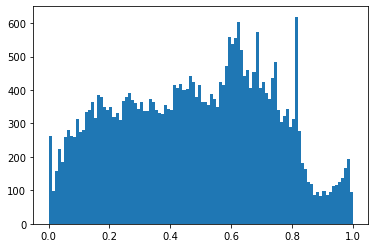

In [25]:
bins = np.linspace(0, 1, nupairplot1)

plt.hist(species_corr, bins=bins)
None

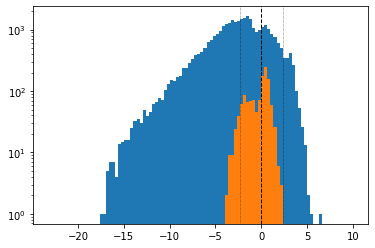

In [26]:
thresh = 0.9
pseudo = 1e-7

bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)
plt.hist(np.log2(species_depth_ratio + pseudo), bins=bins)
plt.hist(np.log2(species_depth_ratio[species_corr > thresh] + pseudo), bins=bins)
plt.yscale('log')

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.axvline(np.log2(0.2), lw=0.5, linestyle=':', color='k')
plt.axvline(np.log2(5), lw=0.5, linestyle=':', color='k')

None

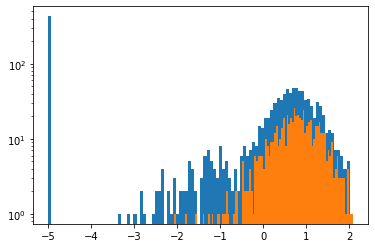

In [27]:
plt.hist(np.log10(species_gene_depth + 1e-5), bins=100)
plt.hist(np.log10(species_gene_depth.loc[idxwhere(strain_frac.max(1) > 0.95)] + 1e-5), bins=100)
plt.yscale('log')
None

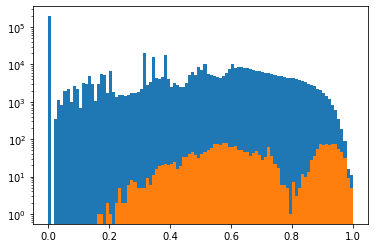

In [1090]:
bins = np.linspace(0, 1, num=101)
plt.hist(strain_corr_99[strain], bins=bins)
plt.hist(strain_corr_99[strain][(strain_depth_99[strain] > 0.5) & (strain_depth_99[strain] < 2)], bins=bins)

plt.yscale('log')
None

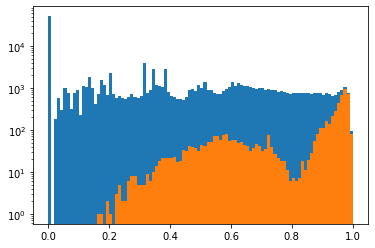

In [1091]:
bins = np.linspace(0, 1, num=101)
plt.hist(strain_corr_95[strain], bins=bins)
plt.hist(strain_corr_95[strain][(strain_depth_95[strain] > 0.5) & (strain_depth_95[strain] < 2)], bins=bins)

plt.yscale('log')
None

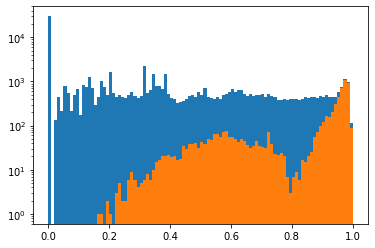

In [1092]:
bins = np.linspace(0, 1, num=101)
plt.hist(strain_corr_90[strain], bins=bins)
plt.hist(strain_corr_90[strain][(strain_depth_90[strain] > 0.5) & (strain_depth_90[strain] < 2)], bins=bins)

plt.yscale('log')
None

In [1205]:
(
    species_depth_ratio[species_corr > 0.95].sum(),
    (strain_depth_95[_strain] * (strain_corr_95[_strain] > q)).groupby(gene_meta.centroid_75).sum().reindex(idxwhere(species_corr > 0.95)).fillna(0).sum(),
)

(2287.1238893072878, 1824.2261774910858)

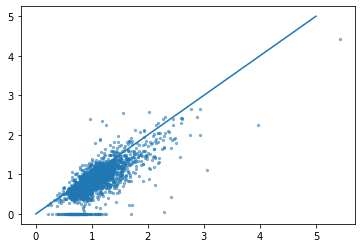

In [1203]:
plt.scatter(
    species_depth_ratio[species_corr > 0.95],
    (strain_depth_95[_strain] * (strain_corr_95[_strain] > q)).groupby(gene_meta.centroid_75).sum().reindex(idxwhere(species_corr > 0.95)).fillna(0),
    s=5, alpha=0.5,
)
plt.plot([0, 5], [0, 5])

centroid_75
UHGG000026_00043    0.862140
UHGG000026_00183    0.824497
UHGG000026_00337    0.931698
UHGG000026_00404    0.758326
UHGG000026_00740    0.897077
                      ...   
UHGG284331_03526    0.622882
UHGG284331_03681    0.845947
UHGG286264_00014    0.512427
UHGG286465_03445    0.604752
UHGG286465_03793    0.745904
Name: 1, Length: 2105, dtype: float64

18944.647980861933

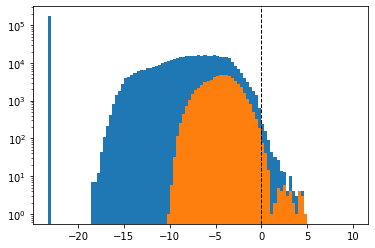

In [1034]:
thresh = 0.9
pseudo = 1e-7

bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)
plt.hist(np.log2(strain_depth_99[strain] + pseudo), bins=bins)
plt.hist(np.log2(strain_depth_99.loc[strain_corr_99[strain] > thresh, strain] + pseudo), bins=bins)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.yscale('log')

None

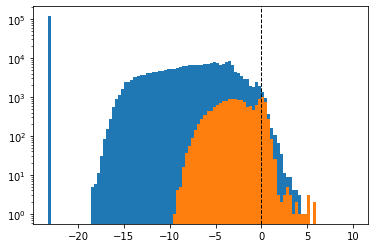

In [1033]:
thresh = 0.9
pseudo = 1e-7

bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)
plt.hist(np.log2(strain_depth_95[strain] + pseudo), bins=bins)
plt.hist(np.log2(strain_depth_95.loc[strain_corr_95[strain] > thresh, strain] + pseudo), bins=bins)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.yscale('log')

None

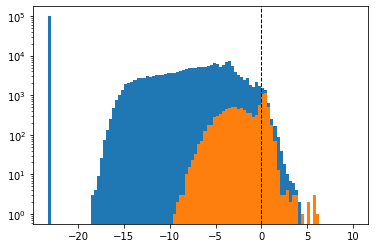

In [1032]:
thresh = 0.9
pseudo = 1e-7

bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)
plt.hist(np.log2(strain_depth_90[strain] + pseudo), bins=bins)
plt.hist(np.log2(strain_depth_90.loc[strain_corr_90[strain] > thresh, strain] + pseudo), bins=bins)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.yscale('log')

None

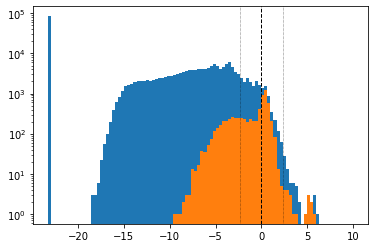

In [1035]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


sample_list = idxwhere(strain_frac[strain] > 0.95)
gene_list = idxwhere(strain_corr_99[strain] > thresh)
d2 = strain_depth_99.loc[:, strain].groupby(gene_meta.centroid_75).sum()
d3 = strain_depth_99.loc[gene_list, strain].groupby(gene_meta.centroid_75).sum()

plt.hist(np.log2(d2 + pseudo), bins=bins)
plt.hist(np.log2(d3 + pseudo), bins=bins)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.axvline(np.log2(0.2), lw=0.5, linestyle=':', color='k')
plt.axvline(np.log2(5), lw=0.5, linestyle=':', color='k')



plt.yscale('log')


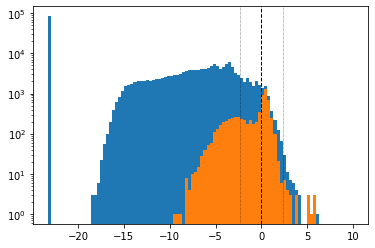

In [1036]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


sample_list = idxwhere(strain_frac[strain] > 0.95)
gene_list = idxwhere(strain_corr_95[strain] > thresh)
d2 = strain_depth_95.loc[:, strain].groupby(gene_meta.centroid_75).sum()
d3 = strain_depth_95.loc[gene_list, strain].groupby(gene_meta.centroid_75).sum()

plt.hist(np.log2(d2 + pseudo), bins=bins)
plt.hist(np.log2(d3 + pseudo), bins=bins)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.axvline(np.log2(0.2), lw=0.5, linestyle=':', color='k')
plt.axvline(np.log2(5), lw=0.5, linestyle=':', color='k')



plt.yscale('log')


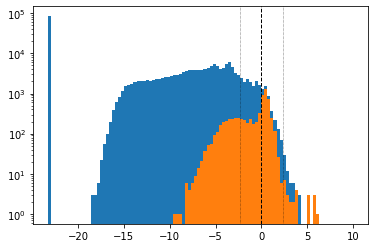

In [1037]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


sample_list = idxwhere(strain_frac[strain] > 0.95)
gene_list = idxwhere(strain_corr_90[strain] > thresh)
d2 = strain_depth_90.loc[:, strain].groupby(gene_meta.centroid_75).sum()
d3 = strain_depth_90.loc[gene_list, strain].groupby(gene_meta.centroid_75).sum()

plt.hist(np.log2(d2 + pseudo), bins=bins)
plt.hist(np.log2(d3 + pseudo), bins=bins)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.axvline(np.log2(0.2), lw=0.5, linestyle=':', color='k')
plt.axvline(np.log2(5), lw=0.5, linestyle=':', color='k')



plt.yscale('log')


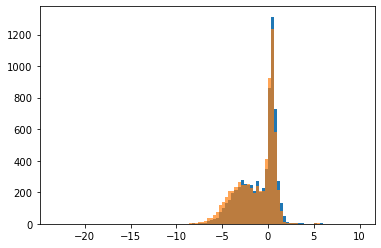

In [1038]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)

aggregate_at = 'centroid_75'


gene99_list = idxwhere(strain_corr_99[strain] > thresh)
gene_agg_list = list(gene_meta.loc[gene99_list][aggregate_at].unique())

d = pd.DataFrame(dict(
    any99=strain_depth_99.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
    hit99 = strain_depth_99.loc[gene99_list, strain].groupby(gene_meta[aggregate_at]).sum(),
))

plt.hist(np.log2(d['any99']), bins=bins)
plt.hist(np.log2(d['hit99']), bins=bins, alpha=0.7)

None

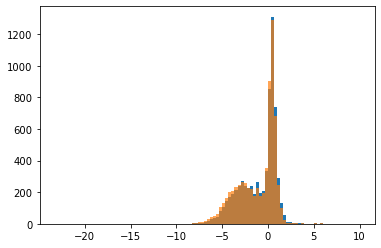

In [1039]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)

aggregate_at = 'centroid_75'


gene95_list = idxwhere(strain_corr_95[strain] > thresh)
gene_agg_list = list(gene_meta.loc[gene95_list][aggregate_at].unique())

d = pd.DataFrame(dict(
    any95=strain_depth_95.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
    hit95 = strain_depth_95.loc[gene95_list, strain].groupby(gene_meta[aggregate_at]).sum(),
))

plt.hist(np.log2(d['any95']), bins=bins)
plt.hist(np.log2(d['hit95']), bins=bins, alpha=0.7)

None

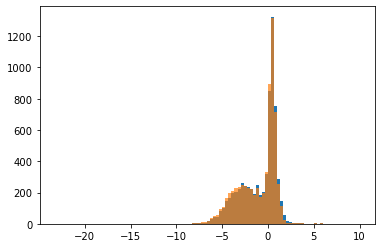

In [1040]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)

aggregate_at = 'centroid_75'


gene90_list = idxwhere(strain_corr_90[strain] > thresh)
gene_agg_list = list(gene_meta.loc[gene90_list][aggregate_at].unique())

d = pd.DataFrame(dict(
    any90=strain_depth_90.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
    hit90 = strain_depth_90.loc[gene90_list, strain].groupby(gene_meta[aggregate_at]).sum(),
))

plt.hist(np.log2(d['any90']), bins=bins)
plt.hist(np.log2(d['hit90']), bins=bins, alpha=0.7)

None

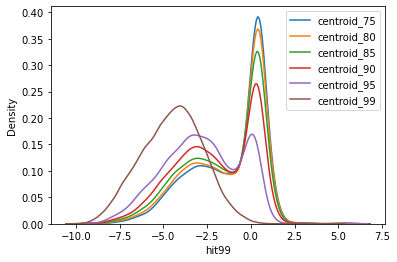

In [1041]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


gene99_list = idxwhere(strain_corr_99[strain] > thresh)

for aggregate_at in reversed(['centroid_99', 'centroid_95', 'centroid_90', 'centroid_85', 'centroid_80', 'centroid_75']):
    gene_agg_list = list(gene_meta.loc[gene99_list][aggregate_at].unique())

    d = pd.DataFrame(dict(
        any99=strain_depth_99.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
        hit99 = strain_depth_99.loc[gene99_list, strain].groupby(gene_meta[aggregate_at]).sum(),
    ))
    # plt.hist(np.log2(d['any99']), bins=bins)
    sns.kdeplot(np.log2(d['hit99']), label=aggregate_at)
plt.legend()

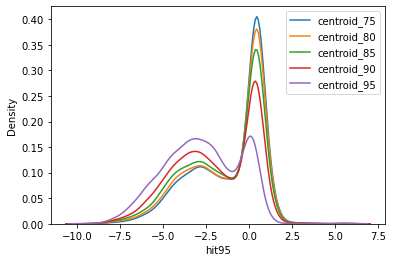

In [1042]:
thresh = 0.9
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


gene95_list = idxwhere(strain_corr_95[strain] > thresh)

for aggregate_at in reversed(['centroid_95', 'centroid_90', 'centroid_85', 'centroid_80', 'centroid_75']):
    gene_agg_list = list(gene_meta.loc[gene95_list][aggregate_at].unique())

    d = pd.DataFrame(dict(
        any95=strain_depth_95.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
        hit95 = strain_depth_95.loc[gene95_list, strain].groupby(gene_meta[aggregate_at]).sum(),
    ))
    # plt.hist(np.log2(d['any95']), bins=bins)
    sns.kdeplot(np.log2(d['hit95']), label=aggregate_at)
plt.legend()

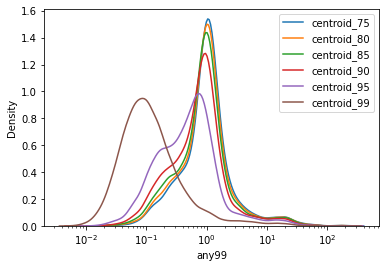

In [963]:
thresh = 0.8
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


gene99_list = idxwhere(strain_corr_99[strain] > thresh)

for aggregate_at in reversed(['centroid_99', 'centroid_95', 'centroid_90', 'centroid_85', 'centroid_80', 'centroid_75']):
    gene_agg_list = list(gene_meta.loc[gene99_list][aggregate_at].unique())

    d = pd.DataFrame(dict(
        any99=strain_depth_99.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
        hit99 = strain_depth_99.loc[gene99_list, strain].groupby(gene_meta[aggregate_at]).sum(),
    ))
    sns.kdeplot(d['any99'], log_scale=True, label=aggregate_at)
plt.legend()

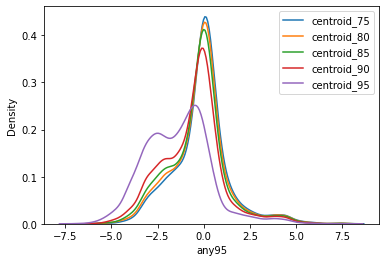

In [964]:
thresh = 0.8
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


gene95_list = idxwhere(strain_corr_95[strain] > thresh)

for aggregate_at in reversed(['centroid_95', 'centroid_90', 'centroid_85', 'centroid_80', 'centroid_75']):
    gene_agg_list = list(gene_meta.loc[gene95_list][aggregate_at].unique())

    d = pd.DataFrame(dict(
        any95=strain_depth_95.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
        hit95 = strain_depth_95.loc[gene95_list, strain].groupby(gene_meta[aggregate_at]).sum(),
    ))
    # plt.hist(np.log2(d['any95']), bins=bins)
    sns.kdeplot(np.log2(d['any95']), label=aggregate_at)
plt.legend()

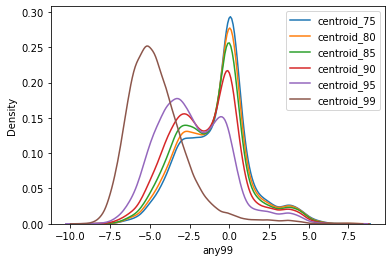

In [965]:
thresh = 0.5
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


gene99_list = idxwhere(strain_corr_99[strain] > thresh)

for aggregate_at in reversed(['centroid_99', 'centroid_95', 'centroid_90', 'centroid_85', 'centroid_80', 'centroid_75']):
    gene_agg_list = list(gene_meta.loc[gene99_list][aggregate_at].unique())

    d = pd.DataFrame(dict(
        any99=strain_depth_99.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
        hit99 = strain_depth_99.loc[gene99_list, strain].groupby(gene_meta[aggregate_at]).sum(),
    ))
    sns.kdeplot(np.log2(d['any99']), label=aggregate_at)
plt.legend()

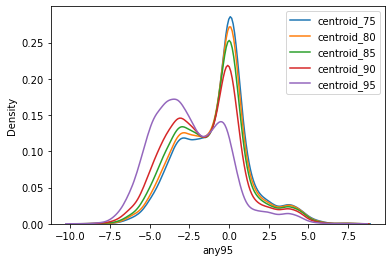

In [966]:
thresh = 0.5
pseudo = 1e-7
bins = np.linspace(np.log2(pseudo), np.log2(1000), num=101)


gene95_list = idxwhere(strain_corr_95[strain] > thresh)

for aggregate_at in reversed(['centroid_95', 'centroid_90', 'centroid_85', 'centroid_80', 'centroid_75']):
    gene_agg_list = list(gene_meta.loc[gene95_list][aggregate_at].unique())

    d = pd.DataFrame(dict(
        any95=strain_depth_95.loc[:, strain].groupby(gene_meta[aggregate_at]).sum().loc[gene_agg_list],
        hit95 = strain_depth_95.loc[gene95_list, strain].groupby(gene_meta[aggregate_at]).sum(),
    ))
    sns.kdeplot(np.log2(d['any95']), label=aggregate_at)
plt.legend()

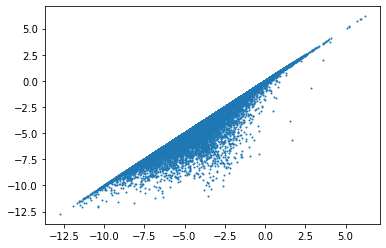

In [883]:
plt.scatter('any99', 'hit99', data=np.log2(d), s=1)

(114, 22609)


/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


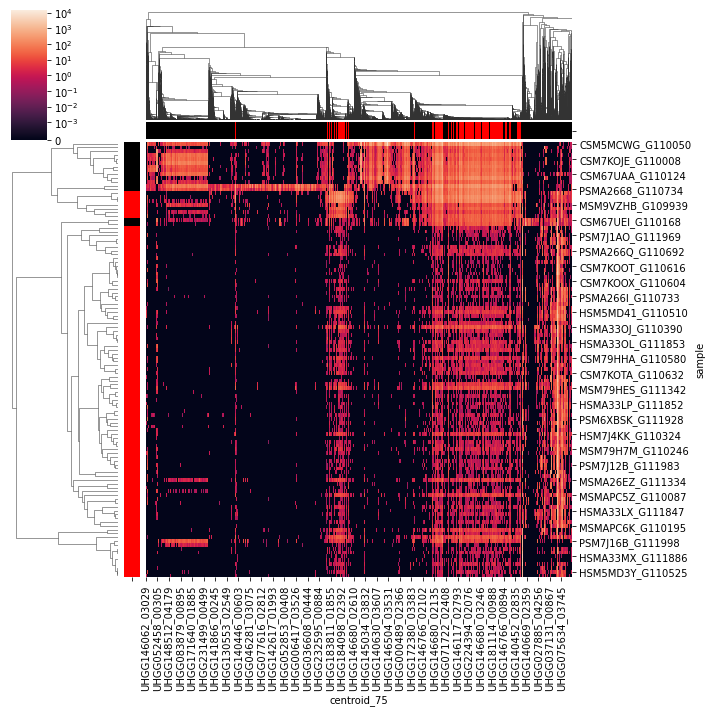

In [727]:
thresh = 0.9

sample_list = idxwhere(strain_frac[strain] > 0.95)
decoy_sample_list = idxwhere((strain_frac[decoy_strains] > 0.95).any(1))

gene_list = idxwhere(strain_corr_99[strain] > thresh)
decoy_gene_list = list(set(idxwhere((strain_corr_99[decoy_strains] > thresh).any(1))) - set(gene_list))

gene75_list = list(gene_meta.loc[gene_list].centroid_75.unique())
decoy_gene75_list = list(set(gene_meta.loc[decoy_gene_list].centroid_75.unique()) - set(gene75_list))

row_colors = pd.Series([0]*len(decoy_sample_list) + [1]*len(sample_list), index=decoy_sample_list + sample_list).map({0: 'black', 1: 'red'})
col_colors = pd.Series([0]*len(decoy_gene75_list) + [1]*len(gene75_list), index=decoy_gene75_list + gene75_list).map({0: 'black', 1: 'red'})

# NOTE: This looks at the summed depth for ALL genes in any strain, not just the correlated genes.
d = gene_depth_99.sel(sample=sample_list + decoy_sample_list, gene_id=gene_list + decoy_gene_list).groupby(gene_meta.centroid_75.to_xarray().sel(gene_id=(gene_list + decoy_gene_list))).sum().to_series().unstack().T
print(d.shape)

sns.clustermap(
    d, metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-3),
    row_colors=row_colors,
    col_colors=col_colors,
)

In [760]:
strain_corr_75

strain,32,1,2,4,5,6,11,43,13,14,15,17,24,25,28,30,31
gene_id,,,,,,,,,,,,,,,,,
UHGG145327_00985,0.722537,0.837118,0.850989,0.908803,0.562412,0.990870,0.995093,0.999865,0.367370,0.848982,0.999641,0.956520,0.996403,0.997841,0.999318,0.801797,0.859499
UHGG085136_03146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293609,0.999698,0.000000,0.000000,0.739763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UHGG012311_03478,0.000000,0.000000,0.382895,0.715640,0.365384,0.000000,0.816505,0.986157,0.328434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.801797,0.369956
UHGG224350_03154,0.593590,0.590852,0.703900,0.000000,0.436199,0.672447,0.752730,0.997100,0.000000,0.775842,0.739763,0.000000,0.000000,0.886340,0.830675,0.000000,0.000000
UHGG180803_01284,0.593590,0.836771,0.575050,0.487562,0.823812,0.705182,0.986556,0.999676,0.758188,0.720685,0.983618,0.715989,0.921411,0.982760,0.956708,0.801797,0.850468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UHGG146023_02749,0.988960,0.978808,0.983661,0.999226,0.991133,0.993228,0.999334,0.999980,0.982665,0.986001,0.999972,0.993928,0.999323,0.999525,0.999140,0.999864,0.977446
UHGG184322_04299,0.000000,0.000000,0.125823,0.000000,0.000000,0.000000,0.000000,0.000000,0.481899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UHGG272480_02220,0.000000,0.452379,0.121172,0.000000,0.000000,0.234129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [761]:
cutoff = 0.95
strain_hit = set(idxwhere(strain_corr_75[strain] > cutoff))
species_hit = set(idxwhere(species_corr > cutoff))

len(species_hit), len(strain_hit), len(species_hit | strain_hit), len(species_hit - strain_hit), len(strain_hit - species_hit)

(2105, 3353, 3611, 258, 1506)

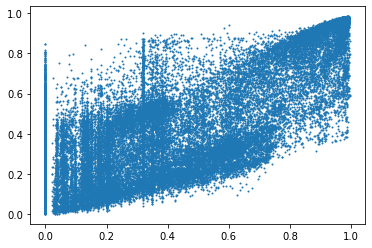

In [768]:
x, y = align_indexes(strain_corr_75[strain], species_corr)

plt.scatter(x, y, s=1)

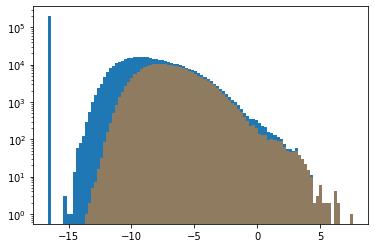

In [321]:
pseudo = 1e-5
d = strain_depth[strain] + pseudo
c = strain_corr[strain]

bins = np.linspace(np.log2(pseudo), np.log2(d.max()), num=101)
plt.hist(np.log2(d), bins=bins)
plt.hist(np.log2(d[c > 0.5]), bins=bins, alpha=0.5)

plt.yscale('log')

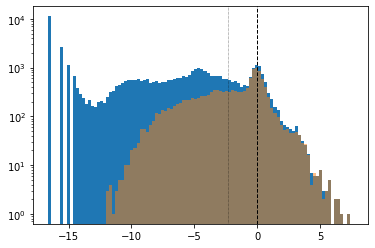

In [331]:
pseudo = 1e-5
cutoff = 0.5
d = strain_depth[strain] + pseudo
c = strain_corr[strain]

bins = np.linspace(np.log2(pseudo), np.log2(d.max()), num=101)
plt.hist(np.log2(d.groupby(gene_meta.centroid_75).sum()), bins=bins)
plt.hist(np.log2(d[c > cutoff].groupby(gene_meta.centroid_75).sum()), bins=bins, alpha=0.5)

plt.axvline(np.log2(1), lw=1, linestyle='--', color='k')
plt.axvline(np.log2(1/5), lw=0.5, linestyle=':', color='k')

plt.yscale('log')

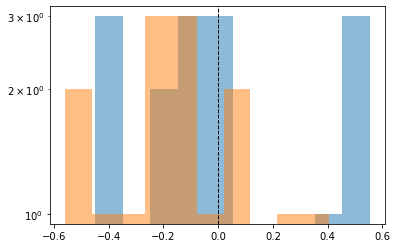

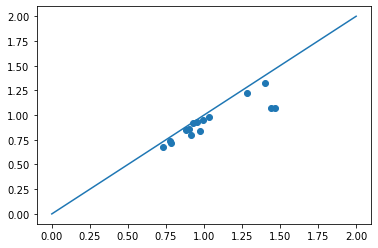

In [332]:
pseudo = 1e-5
cutoff = 0.5
d = strain_depth[strain] + pseudo
c = strain_corr[strain]

bins = None  # np.linspace(np.log2(pseudo), np.log2(d.max()), num=101)
# plt.hist(np.log2(d.groupby(gene_meta.centroid_75).sum()), bins=bins)
# plt.hist(np.log2(d[c > cutoff].groupby(gene_meta.centroid_75).sum()), bins=bins, alpha=0.5)

plt.figure()
plt.hist(np.log2(d.groupby(gene_meta.marker_id).sum()), bins=bins, alpha=0.5)
plt.hist(np.log2(d[(c > cutoff)].groupby(gene_meta.marker_id).sum()), bins=bins, alpha=0.5)
plt.axvline(0, lw=1, linestyle='--', color='k')
plt.yscale('log')


plt.figure()
plt.scatter(x='_all', y='_hit', data=pd.DataFrame(dict(_all=d.groupby(gene_meta.marker_id).sum(), _hit=d[(c > cutoff)].groupby(gene_meta.marker_id).sum())))
plt.plot([0, 2], [0, 2])

In [333]:
species_gene_list = idxwhere(species_corr > 0.95)
len(species_gene_list)

2105

In [334]:
mean_gene_depth = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas.species_gene_depth_ratio.tsv', names=['sample', 'depth'], index_col='sample').squeeze()

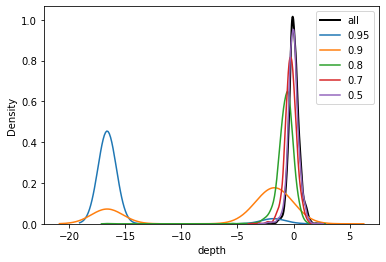

In [335]:
bins = np.linspace(-5, 5, num=101)

species_hit = idxwhere(species_corr > 0.95)
sns.kdeplot(np.log2(mean_gene_depth[species_hit] + 1e-5), label='all', color='k', lw=2)

for cutoff in [0.95, 0.9, 0.8, 0.7, 0.5]:
    sns.kdeplot(np.log2(strain_depth[strain][strain_corr[strain] > cutoff].groupby(gene_meta.centroid_75).sum().reindex(species_hit).fillna(0) + 1e-5), label=cutoff)
plt.legend()


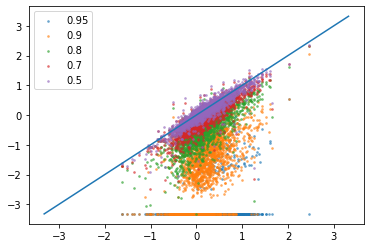

In [336]:
bins = np.linspace(-5, 5, num=101)
pseudo = 1e-1

species_hit = idxwhere(species_corr > 0.95)

for cutoff in [0.95, 0.9, 0.8, 0.7, 0.5]:
    plt.scatter(
        np.log2(mean_gene_depth[species_hit] + pseudo),
        np.log2(strain_depth[strain][strain_corr[strain] > cutoff].groupby(gene_meta.centroid_75).sum().reindex(species_hit).fillna(0) + pseudo),
        label=cutoff,
        s=3,
        alpha=0.5,
    )
plt.plot([np.log2(pseudo), np.log2(1e1)], [np.log2(pseudo), np.log2(1e1)])
plt.legend()


In [337]:
strain_depth[strain][strain_corr[strain] > cutoff].groupby(gene_meta.centroid_75).sum().reindex(species_hit).isna().sum()

0

0.5 12529.563137012006
0.7 5138.193682083483
0.8 3909.395527711754
0.9 1555.4953416225521
0.95 257.0366303027647


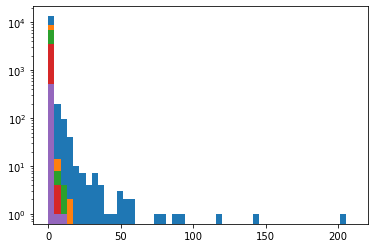

In [338]:
bins = np.linspace(0, 210)  # np.linspace(-5, 5, num=101)

for cutoff in reversed([0.95, 0.9, 0.8, 0.7, 0.5]):
    d = strain_depth[strain][strain_corr[strain] > cutoff].groupby(gene_meta.centroid_75).sum()
    plt.hist(d, bins=bins)
    print(cutoff, d.sum())

plt.yscale('log')

In [339]:
print(strain_depth[strain][strain_corr[strain] > 0.7].groupby(gene_meta.centroid_75).sum().sum())

5138.193682083483


In [340]:
for cutoff in [0.99, 0.95, 0.9, 0.8, 0.7, 0.5, 0]:
    x = mean_gene_depth[species_hit] + pseudo
    y = strain_depth[strain][strain_corr[strain] > cutoff].groupby(gene_meta.centroid_75).sum().reindex(species_hit).fillna(0)
    print(cutoff, y.sum(), y.sum() / x.sum(), x.sum())

0.99 0.0 0.0 2497.6238893072873
0.95 48.87381681042564 0.019568125136719735 2497.6238893072873
0.9 565.7745412501208 0.22652511600016673 2497.6238893072873
0.8 1446.926465218549 0.579321198605228 2497.6238893072873
0.7 1892.9852747640725 0.7579144653717615 2497.6238893072873
0.5 2188.2416173526444 0.8761293590763781 2497.6238893072873
0 2265.2811572879946 0.9069744916302299 2497.6238893072873


(array([  4.,   1.,   2.,   5.,   5.,   8.,   5.,   9.,   9.,  32.,  54.,
         44.,  72.,  94., 117., 136., 162., 195., 199., 209., 219., 247.,
        251., 259., 207., 258., 246., 266., 280., 262., 342., 516., 724.,
        915., 838., 663., 405., 201.,  89.,  43.,   6.,   6.,   5.,   5.,
          5.,   3.,   0.,   4.,   1.,   1.]),
 array([-9.2704718 , -9.00348336, -8.73649491, -8.46950647, -8.20251802,
        -7.93552958, -7.66854114, -7.40155269, -7.13456425, -6.8675758 ,
        -6.60058736, -6.33359892, -6.06661047, -5.79962203, -5.53263359,
        -5.26564514, -4.9986567 , -4.73166825, -4.46467981, -4.19769137,
        -3.93070292, -3.66371448, -3.39672603, -3.12973759, -2.86274915,
        -2.5957607 , -2.32877226, -2.06178382, -1.79479537, -1.52780693,
        -1.26081848, -0.99383004, -0.7268416 , -0.45985315, -0.19286471,
         0.07412374,  0.34111218,  0.60810062,  0.87508907,  1.14207751,
         1.40906595,  1.6760544 ,  1.94304284,  2.21003129,  2.47701973,
 

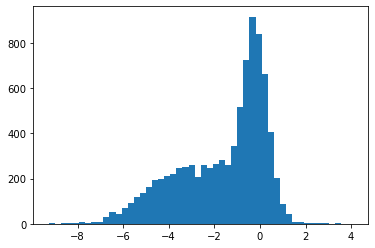

In [344]:
plt.hist(np.log2(strain_depth[strain][strain_corr[strain] > 0.7].groupby(gene_meta.centroid_75).sum().fillna(0)), bins=50)

In [265]:
gene_depth_75 = gene_depth.groupby(gene_meta.loc[gene_depth.gene_id].centroid_75.to_xarray()).sum().rename(dict(centroid_75='gene_id'))

In [397]:
d = (
    gene_depth
    .sel(gene_id=idxwhere(strain_corr[strain] > 0.7), sample=idxwhere(strain_frac[strain] > 0.95))
    .to_series()
    .unstack()
    .groupby(gene_meta.centroid_75)
    .sum()
)
# d = d / species_gene_depth.loc[d.columns]

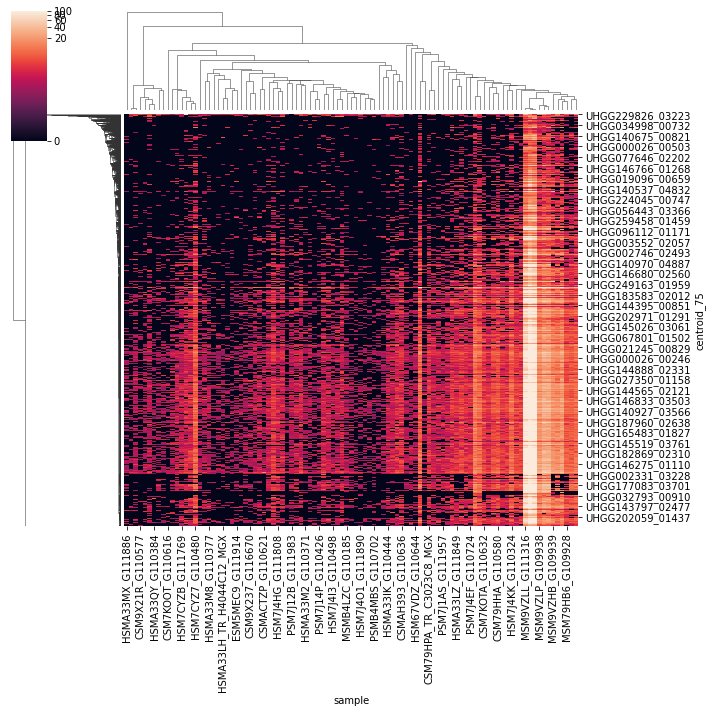

In [401]:
sns.clustermap(d, norm=mpl.colors.PowerNorm(1/7, vmin=0.1, vmax=100), metric='cosine')

(array([2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 7.000e+00,
        1.200e+01, 1.700e+01, 2.100e+01, 2.600e+01, 2.600e+01, 4.000e+01,
        5.000e+01, 5.600e+01, 8.500e+01, 1.190e+02, 1.270e+02, 1.620e+02,
        1.620e+02, 1.920e+02, 2.130e+02, 2.370e+02, 2.590e+02, 2.820e+02,
        3.350e+02, 3.280e+02, 3.580e+02, 3.760e+02, 4.360e+02, 5.480e+02,
        7.860e+02, 1.144e+03, 1.020e+03, 7.080e+02, 2.910e+02, 1.130e+02,
        3.500e+01, 1.400e+01, 9.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00]),
 array([-12.17186038, -11.78053328, -11.38920618, -10.99787908,
        -10.60655198, -10.21522488,  -9.82389778,  -9.43257068,
         -9.04124358,  -8.64991648,  -8.25858938,  -7.86726228,
         -7.47593518,  -7.08460808,  -6.69328098,  -6.30195388,
         -5.91062678,  -5.51929968,  -5.12797258,  -4.73664548,
         -4.34531837,  -3.95399127,  -3.56266

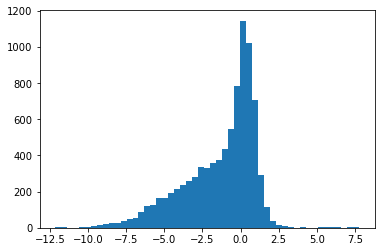

In [371]:
plt.hist(np.log2(d.mean(1)), bins=51)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

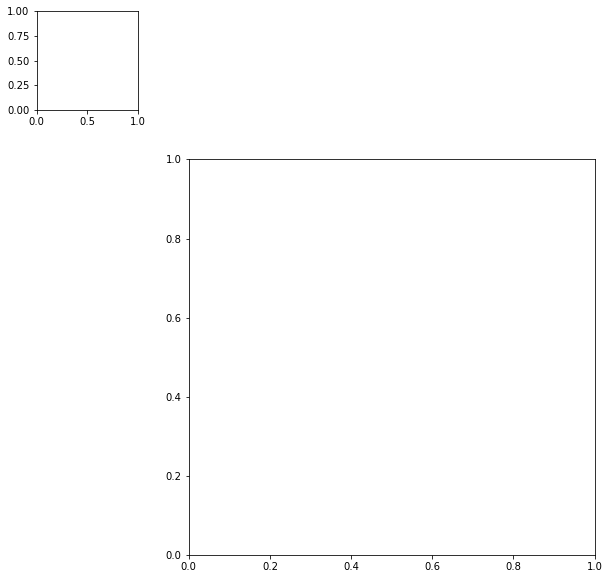

In [310]:
sns.clustermap(np.log2(d), metric='cosine')